<div style="background-color: black; padding: 30px; color: white; width: 100%; position: relative; font-family: Arial, sans-serif;">
    <div style="text-align: center; font-size: 20px; font-weight: bold; margin-bottom: 30px; margin: 22px;">
        Fine-tuning of YOLOv8n-pose for animal pose estimation<br>
        YOLOv8n-pose + DATASET HORSE10
    </div>
    <div style="position: absolute; top: 0; left: 20px; font-size: 16px; margin: 20px;">
        05 May 2024
    </div>
</div>


# ✅ **Final resulat : Links to Original Video and Detection Results**

- **Original Video**: [View Original Video](https://drive.google.com/file/d/1xacAnKF2GRVQgkKQ6ZJVh9nxK32OiwPo/view?usp=sharing)

- **Detection Results**: [View Detection Results](https://drive.google.com/file/d/1BfpUYE025wUy77HUX5OLhdTzginOHqqu/view?usp=sharing)


# ✅ **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ✅ **Imports :**

In [ ]:
from google.colab import drive
import os
import requests
from io import BytesIO
from PIL import Image
import zipfile
import json
import tarfile
import numpy as np
from dataclasses import dataclass, field
import cv2
!pip install ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import glob
import cv2
import matplotlib.pyplot as plt
import os
import json
from shutil import copyfile
import matplotlib.image as mpimg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.5/756.5 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
 !pip install ultralytics

# ✅ **Data Understanding**

Horse-10 is an animal pose estimation dataset. It comprises 30 diverse Thoroughbred horses, for which 22 body parts were labeled by an expert in 8,114 frames (animal pose estimation). Horses have various coat colors and the “in-the-wild” aspect of the collected data at various Thoroughbred yearling sales and farms added additional complexity.

# ✅ **Data preparation**

## ☑ **Merge Data**

In [ ]:
def merge_json_files(file_paths,output_file):
    merged_data = {"images": [], "annotations": [], "categories": []}

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)

            merged_data["images"].extend(data["images"])

            merged_data["annotations"].extend(data["annotations"])

            merged_data["categories"].extend(data["categories"])

    with open(output_file, 'w') as outfile:
        json.dump(merged_data, outfile,indent=4)

In [ ]:
file_paths = ['/content/drive/MyDrive/Horse-10/annotations/horse10-train-split1.json', '/content/drive/MyDrive/Horse-10/annotations/horse10-train-split2.json', '/content/drive/MyDrive/Horse-10/annotations/horse10-train-split3.json']  # Replace with the paths of your JSON files
output_file = '/content/drive/MyDrive/Horse-10/annotations/horse10-train.json'  # Path of the output merged JSON file

merge_json_files(file_paths, output_file)

In [ ]:
file_paths = ['/content/drive/MyDrive/Horse-10/annotations/horse10-test-split1.json', '/content/drive/MyDrive/Horse-10/annotations/horse10-test-split2.json', '/content/drive/MyDrive/Horse-10/annotations/horse10-test-split3.json']  # Replace with the paths of your JSON files
output_file = '/content/drive/MyDrive/Horse-10/annotations/horse10-test.json'  # Path of the output merged JSON file

merge_json_files(file_paths, output_file)

# ☑ **Split Data**

In [ ]:
def split_merged_json(input_file, train_output_file, valid_output_file, split_ratio=0.3):
    with open(input_file, 'r') as file:
        data = json.load(file)
    train_size = int(len(data['images']) * split_ratio)
    train_data = {key: data[key][:1500] for key in data.keys()}
    valid_data = {key: data[key][1500:1700] for key in data.keys()}
    with open(train_output_file, 'w') as train_file:
        json.dump(train_data, train_file, indent=4)
    with open(valid_output_file, 'w') as valid_file:
        json.dump(valid_data, valid_file, indent=4)


input_file = '/content/drive/MyDrive/Horse-10/annotations/horse10-train.json'
train_output_file = '/content/drive/MyDrive/Horse-10/annotations/train.json'
valid_output_file = '/content/drive/MyDrive/Horse-10/annotations/valid.json'

split_merged_json(input_file, train_output_file, valid_output_file)


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Horse-10"

TRAIN_DIR         = f"train"
TRAIN_FOLDER_IMG    = f"images"
TRAIN_FOLDER_LABELS = f"labels"

TRAIN_IMG_PATH   = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_IMG)
TRAIN_LABEL_PATH = os.path.join(DATA_DIR, TRAIN_DIR, TRAIN_FOLDER_LABELS)

VALID_DIR           = f"valid"
VALID_FOLDER_IMG    = f"images"
VALID_FOLDER_LABELS = f"labels"

VALID_IMG_PATH   = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_IMG)
VALID_LABEL_PATH = os.path.join(DATA_DIR, VALID_DIR, VALID_FOLDER_LABELS)

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(TRAIN_LABEL_PATH, exist_ok=True)
os.makedirs(VALID_IMG_PATH, exist_ok=True)
os.makedirs(VALID_LABEL_PATH, exist_ok=True)

In [ ]:
def copy_images_from_json(input_file, output_path):

    with open(input_file, 'r') as file:
        json_data = json.load(file)


    for data in json_data['images']:
        img_file = data["file_name"]
        filename = str(data['id']) + '.png'

        copyfile(os.path.join('/content/drive/MyDrive/Horse-10', img_file),
                 os.path.join(output_path, filename))



In [ ]:
input_file_path = '/content/drive/MyDrive/Horse-10/annotations/train.json'
output_directory_path = '/content/drive/MyDrive/Horse-10/train/images'
copy_images_from_json(input_file_path, output_directory_path)

In [ ]:
input_file_path = '/content/drive/MyDrive/Horse-10/annotations/valid.json'
output_directory_path = '/content/drive/MyDrive/Horse-10/valid/images'
copy_images_from_json(input_file_path, output_directory_path)

In preparing the **Horse-10** dataset for training with YOLOv8, we first merged JSON files containing image, annotation, and category data. Then, we split this merged data into training and validation subsets, allocating images and their corresponding annotations based on a specified ratio. Furthermore, we organized the dataset by creating separate folders for images and their labels, ensuring compatibility with YOLOv8's input requirements.

# ☑ **Data Processing to YoloV8 format**

In [ ]:
def create_yolo_boxes_kpts(img_size, boxes, lm_kpts):

    IMG_W, IMG_H = img_size

    res_box_array = np.array([IMG_W, IMG_H, IMG_W, IMG_H])
    res_lm_array = np.array([IMG_W, IMG_H])

    norm_kps_per_img = lm_kpts.copy()
    l=len(norm_kps_per_img)
    i=1
    while i<=l:
      norm_kps_per_img[i-1]=norm_kps_per_img[i-1]/IMG_W
      norm_kps_per_img[i]=norm_kps_per_img[i]/IMG_H
      i=i+3

    norm_bbox_per_img = boxes / res_box_array


    yolo_boxes = norm_bbox_per_img.copy()
    yolo_boxes[:2] = norm_bbox_per_img[:2] + norm_bbox_per_img[2:]/2.

    return yolo_boxes, norm_kps_per_img

In [ ]:
def create_yolo_txt_files(json_file, LABEL_PATH):
    with open(json_file, 'r') as file:
        json_data = json.load(file)

    for img_data,annotation_data in  zip(json_data['images'],json_data['annotations']):


        IMAGE_ID = img_data["id"]

        IMG_WIDTH, IMG_HEIGHT = img_data["width"], img_data["height"]

        landmark_kpts  = np.nan_to_num(np.array(annotation_data["keypoints"], dtype=np.float32))
        landmarks_bboxes = np.array(annotation_data["bbox"], dtype=np.float32)
        if len(landmark_kpts)!=66:
          print("false")
        bboxes_yolo, kpts_yolo = create_yolo_boxes_kpts(
                                            (IMG_WIDTH, IMG_HEIGHT),
                                            landmarks_bboxes,
                                            landmark_kpts)

        TXT_FILE = str(IMAGE_ID)+".txt"

        with open(os.path.join(LABEL_PATH, TXT_FILE), "w") as f:

            x_c_norm, y_c_norm, box_width_norm, box_height_norm = round(bboxes_yolo[0],5),\
                                                                  round(bboxes_yolo[1],5),\
                                                                  round(bboxes_yolo[2],5),\
                                                                  round(bboxes_yolo[3],5),\

            kps_flattend = [round(ele,5) for ele in kpts_yolo.flatten().tolist()]
            line = f"{CLASS_ID} {x_c_norm} {y_c_norm} {box_width_norm} {box_height_norm} "
            line+= " ".join(map(str, kps_flattend))
            f.write(line)

In [ ]:
input_file_path = '/content/drive/MyDrive/Horse-10/annotations/train.json'
create_yolo_txt_files(input_file_path, TRAIN_LABEL_PATH)

In [ ]:
input_file_path = '/content/drive/MyDrive/Horse-10/annotations/valid.json'
create_yolo_txt_files(input_file_path, VALID_LABEL_PATH)

# ✅ **YOLOv8-n Traininig**

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    DATASET_YAML:   str = "horse-keypoints.yaml"
    MODEL:          str = "yolov8n-pose.pt"
    EPOCHS:         int = 100
    KPT_SHAPE:    tuple = (22,3)
    PROJECT:        str = "Horse_Keypoints"
    NAME:           str = f"{MODEL.split('.')[0]}_{EPOCHS}_epochs"
    CLASSES_DICT:  dict = field(default_factory = lambda:{0 : "horse"})

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    BATCH_SIZE:    int   = 16
    CLOSE_MOSAIC:  int   = 10
    MOSAIC:        float = 0.4
    FLIP_LR:       float = 0.0

In [ ]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [ ]:
current_dir = os.getcwd()

data_dict = dict(
                path      = DATA_DIR,
                train     = os.path.join(TRAIN_DIR, TRAIN_FOLDER_IMG),
                val       = os.path.join(VALID_DIR, VALID_FOLDER_IMG),
                names     = train_config.CLASSES_DICT,
                kpt_shape = list(train_config.KPT_SHAPE),
               )

with open(train_config.DATASET_YAML, "w") as config_file:
    yaml.dump(data_dict, config_file)

In [ ]:
pose_model = model = YOLO(train_config.MODEL)

pose_model.train(data    = train_config.DATASET_YAML,
            epochs       = train_config.EPOCHS,
            batch        = data_config.BATCH_SIZE,
            project      = train_config.PROJECT,
            name         = train_config.NAME,
            close_mosaic = data_config.CLOSE_MOSAIC,
            mosaic       = data_config.MOSAIC,
            fliplr       = data_config.FLIP_LR
                 )

100%|██████████| 6.51M/6.51M [00:00<00:00, 119MB/s]


Ultralytics YOLOv8.2.4 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=horse-keypoints.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Horse_Keypoints, name=yolov8n-pose_100_epochs, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[22, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1 

100%|██████████| 6.23M/6.23M [00:00<00:00, 118MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Horse-10/train/labels.cache... 1500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Horse-10/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to Horse_Keypoints/yolov8n-pose_100_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to Horse_Keypoints/yolov8n-pose_100_epochs
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      1.242      9.246     0.6508      1.108      1.444         20        640: 100%|██████████| 94/94 [05:07<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200        200      0.984      0.934      0.967      0.761     0.0116      0.015    0.00064   0.000347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.42G       0.92      6.846     0.5384     0.6777      1.164         12        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


                   all        200        200      0.934      0.917      0.952      0.746      0.548       0.44      0.264     0.0463

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.41G     0.8876        5.9     0.5002     0.6614      1.132         14        640: 100%|██████████| 94/94 [00:34<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all        200        200      0.975      0.825      0.923      0.759      0.801      0.584      0.569       0.13



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.41G     0.8689       5.57     0.4532     0.6465      1.123         23        640: 100%|██████████| 94/94 [00:35<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200        200       0.94       0.92      0.957      0.789      0.764       0.61      0.605      0.121



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.41G     0.8086      5.263     0.4244       0.61      1.095         16        640: 100%|██████████| 94/94 [00:34<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        200        200       0.96       0.96      0.977      0.837      0.739      0.655      0.535      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.41G     0.8007      4.996     0.3985      0.582      1.084         20        640: 100%|██████████| 94/94 [00:35<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.39it/s]

                   all        200        200      0.966        0.9      0.942      0.827      0.787       0.65       0.62      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.41G     0.7876      4.884     0.3715     0.5819       1.08         22        640: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

                   all        200        200      0.994      0.895      0.938      0.755      0.831       0.67      0.612       0.14



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.41G     0.7518      4.569     0.3505     0.5479      1.051         15        640: 100%|██████████| 94/94 [00:34<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        200        200      0.969      0.938      0.971       0.83      0.868      0.785      0.817      0.236



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.41G     0.7475      4.388     0.3298     0.5502      1.043         21        640: 100%|██████████| 94/94 [00:34<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200        200      0.994      0.885      0.956      0.807      0.827       0.66      0.608      0.185



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.41G     0.7369      4.289      0.328       0.55      1.042         27        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        200        200      0.976       0.93      0.973      0.858       0.97       0.81       0.84      0.249



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.41G     0.7096      4.133     0.3158     0.5318      1.024         22        640: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200        200      0.968      0.919      0.951      0.825      0.872       0.77      0.783      0.299



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.41G     0.6945      3.906     0.3034     0.4987       1.02         16        640: 100%|██████████| 94/94 [00:35<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        200        200      0.978      0.925      0.978      0.876      0.976      0.827      0.886      0.366



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.41G     0.6872       3.52     0.2919     0.5031      1.016         22        640: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


                   all        200        200      0.981       0.93      0.961      0.857      0.956       0.86      0.885      0.442

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.41G     0.6543      3.347     0.2854      0.484      1.003         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


                   all        200        200      0.998      0.935      0.987      0.867      0.913       0.75      0.793      0.398

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.41G     0.6506      3.048     0.2755     0.4846     0.9978         21        640: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200        200      0.961       0.94      0.973      0.858      0.929        0.8       0.85       0.38



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.41G     0.6435      2.803     0.2651     0.4648     0.9954         19        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


                   all        200        200      0.964      0.945      0.986      0.887      0.938      0.845       0.88      0.584

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.41G     0.6242      2.658     0.2668     0.4573     0.9895         13        640: 100%|██████████| 94/94 [00:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200        200      0.988      0.925      0.979      0.869      0.926      0.882      0.908      0.576



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.41G     0.6275      2.663      0.266     0.4577     0.9934         16        640: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all        200        200      0.974      0.924      0.971      0.872      0.947      0.899       0.92       0.57



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.41G       0.61       2.44     0.2599     0.4548     0.9742         18        640: 100%|██████████| 94/94 [00:37<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        200        200      0.984       0.94      0.977      0.866      0.931       0.89      0.925      0.648



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.41G     0.5815      2.299     0.2674     0.4337     0.9687         20        640: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        200        200      0.999      0.935      0.982      0.867      0.941      0.885      0.917      0.593



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.41G     0.5982      2.405     0.2589     0.4272     0.9635         17        640: 100%|██████████| 94/94 [00:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        200        200      0.964      0.943      0.984      0.888       0.92        0.9      0.923      0.571



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.41G     0.5732      2.283     0.2611     0.4249     0.9675         25        640: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]

                   all        200        200      0.998      0.935      0.982      0.891      0.937        0.9      0.939      0.685



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.41G     0.5713      2.147     0.2495     0.4301     0.9558         16        640: 100%|██████████| 94/94 [00:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        200        200      0.979       0.93      0.966      0.862      0.951      0.872      0.903      0.623



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.41G     0.5774      2.175     0.2453     0.4296     0.9617         15        640: 100%|██████████| 94/94 [00:34<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        200        200      0.984      0.944      0.988      0.883      0.979      0.939      0.965      0.678



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.41G       0.59        2.2     0.2526      0.445     0.9732         15        640: 100%|██████████| 94/94 [00:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


                   all        200        200       0.98       0.94       0.98      0.884      0.917       0.88      0.892      0.607

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.41G     0.5541      2.048     0.2486     0.4211     0.9543         23        640: 100%|██████████| 94/94 [00:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        200        200      0.982       0.92      0.974      0.874      0.957       0.89      0.912      0.627



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.41G     0.5612      1.905     0.2423     0.4125     0.9508         15        640: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        200        200      0.989      0.935      0.978      0.889      0.966        0.9       0.92      0.605



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.41G     0.5648      2.017     0.2382     0.4206     0.9511         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

                   all        200        200      0.994       0.93      0.986      0.892      0.953      0.912      0.931      0.614



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.41G     0.5583      1.988     0.2459      0.412     0.9534         13        640: 100%|██████████| 94/94 [00:35<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        200        200      0.965      0.967      0.988      0.882      0.983      0.935      0.963       0.69



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.41G     0.5492      1.892     0.2399     0.4131     0.9429         20        640: 100%|██████████| 94/94 [00:36<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200        200      0.993      0.935      0.988      0.892      0.947      0.915      0.935      0.646



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.41G     0.5447      1.887     0.2322     0.4121     0.9489         21        640: 100%|██████████| 94/94 [00:34<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

                   all        200        200      0.993      0.935      0.988       0.88      0.942      0.885      0.909      0.613



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.41G     0.5487      1.801     0.2399     0.4059     0.9443         20        640: 100%|██████████| 94/94 [00:34<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200        200      0.998      0.895      0.942      0.855      0.968       0.91      0.924      0.594



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.41G     0.5675      1.897     0.2335     0.4175     0.9606         25        640: 100%|██████████| 94/94 [00:35<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        200        200      0.989      0.932      0.987      0.907      0.954      0.945      0.966      0.709



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.41G     0.5268      1.826     0.2284     0.3899     0.9377         17        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


                   all        200        200      0.997       0.94      0.971      0.884      0.978       0.93      0.946      0.716

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.41G     0.5343      1.745     0.2273     0.3994     0.9476         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        200        200          1       0.94      0.979      0.889      0.965      0.915      0.939      0.652



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.41G     0.5235      1.722     0.2259     0.3879     0.9416         13        640: 100%|██████████| 94/94 [00:34<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


                   all        200        200          1      0.925      0.968      0.879      0.969      0.915      0.955       0.69

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.41G     0.5222      1.607     0.2275     0.3819      0.941         13        640: 100%|██████████| 94/94 [00:36<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        200        200      0.995       0.94      0.986      0.888      0.983      0.935      0.978      0.752



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.41G     0.5257      1.673     0.2175     0.3846     0.9339         23        640: 100%|██████████| 94/94 [00:34<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        200        200          1      0.928      0.978      0.897      0.968      0.916      0.947      0.697



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.41G     0.5099      1.689     0.2289     0.3867     0.9337         15        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

                   all        200        200      0.989       0.94      0.989      0.894      0.978       0.93      0.955      0.722



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.41G     0.5054      1.696     0.2248     0.3738     0.9281         15        640: 100%|██████████| 94/94 [00:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

                   all        200        200      0.995      0.925      0.986      0.903      0.979       0.91      0.951      0.719



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.41G     0.5057      1.619     0.2176     0.3799     0.9258         16        640: 100%|██████████| 94/94 [00:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

                   all        200        200      0.983       0.94      0.982      0.892      0.978      0.935      0.956       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.41G     0.5072      1.616     0.2201     0.3803     0.9339         23        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        200        200      0.997       0.94      0.987        0.9       0.96       0.91      0.933      0.729



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.41G     0.5011      1.639     0.2179     0.3737     0.9315         25        640: 100%|██████████| 94/94 [00:34<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        200        200      0.995      0.915      0.954      0.872      0.968        0.9      0.904      0.728

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.41G     0.4919      1.492     0.2135     0.3808     0.9271         16        640: 100%|██████████| 94/94 [00:35<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        200        200      0.955      0.965      0.988      0.889      0.977      0.935      0.968      0.708



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.41G      0.491      1.488     0.2165      0.372      0.926         26        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        200        200      0.996      0.925      0.983      0.896      0.983       0.92      0.958      0.753



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.41G     0.4809      1.445     0.2178     0.3568     0.9184         19        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        200        200      0.984       0.94      0.988      0.902      0.974      0.934      0.963       0.72



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.41G     0.4704      1.369     0.2129     0.3493       0.92         20        640: 100%|██████████| 94/94 [00:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200        200      0.988       0.94      0.988      0.898      0.979      0.934      0.965      0.778



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.41G     0.4713      1.442     0.2121     0.3501     0.9164         34        640: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]

                   all        200        200      0.971      0.955      0.984      0.903       0.99      0.945      0.966      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.41G     0.4846      1.477     0.2055      0.351     0.9211         19        640: 100%|██████████| 94/94 [00:34<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        200        200      0.998       0.94      0.987      0.921          1      0.954      0.982      0.793



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.41G     0.4597      1.318     0.2068     0.3408     0.9067         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


                   all        200        200      0.988       0.94      0.989      0.879      0.967       0.92      0.959      0.761

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.41G     0.4723      1.314     0.2048     0.3518     0.9123         12        640: 100%|██████████| 94/94 [00:36<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        200        200       0.99      0.944      0.986       0.91      0.988       0.94      0.976       0.79



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.41G     0.4658       1.33     0.1976     0.3556     0.9153         12        640: 100%|██████████| 94/94 [00:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        200        200          1      0.938      0.988      0.909      0.989      0.942      0.976      0.752



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.41G     0.4686      1.243     0.2101     0.3462     0.9154         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        200        200      0.992      0.935      0.981      0.912      0.948      0.919      0.939      0.752



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.41G     0.4539      1.261      0.204     0.3375     0.9065         15        640: 100%|██████████| 94/94 [00:34<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200        200      0.995      0.935       0.99      0.915      0.985      0.953      0.972      0.758



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.41G     0.4583      1.296     0.2094     0.3426     0.9127         11        640: 100%|██████████| 94/94 [00:37<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        200        200      0.998       0.94      0.989      0.911       0.97       0.96      0.969      0.743



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.41G     0.4376      1.305     0.2058     0.3254     0.9021         17        640: 100%|██████████| 94/94 [00:35<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200        200      0.996      0.935      0.985      0.909      0.974      0.925       0.95      0.754



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.41G     0.4326      1.245     0.2022     0.3274     0.9019         13        640: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        200        200      0.984      0.931      0.988      0.911      0.977       0.93       0.97      0.785



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.41G     0.4401      1.226     0.2007     0.3325     0.9078         14        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        200        200      0.979      0.936      0.987       0.91      0.979      0.912      0.962      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.41G     0.4324      1.121     0.1926     0.3209     0.8992         14        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        200        200      0.991      0.945       0.99      0.922       0.99      0.949      0.973      0.793



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.41G     0.4312      1.247      0.202     0.3152     0.8998         23        640: 100%|██████████| 94/94 [00:33<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        200        200      0.967       0.96      0.992       0.93      0.978       0.95      0.971      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.41G     0.4334      1.155     0.1922     0.3278     0.9008         20        640: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        200        200      0.996       0.94      0.988       0.91      0.968       0.93      0.963      0.784



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.41G     0.4266      1.171      0.196     0.3222     0.8933         23        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        200        200          1      0.945      0.984        0.9      0.991      0.935      0.975      0.772



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.41G      0.428      1.166     0.1974     0.3258     0.8979         16        640: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        200        200      0.995       0.94      0.987        0.9       0.99      0.954      0.982      0.768



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.41G     0.4296      1.153     0.1965     0.3218     0.9007         23        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        200        200      0.995      0.935       0.99      0.914      0.982      0.935      0.969      0.781



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.41G      0.404      1.097     0.1947     0.3096     0.8959         16        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.44it/s]


                   all        200        200       0.99      0.948       0.99      0.914      0.995      0.964      0.986      0.805

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.41G     0.4143      1.078     0.1939     0.3135     0.8924         16        640: 100%|██████████| 94/94 [00:33<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        200        200      0.994       0.94       0.99      0.905      0.979      0.965      0.984      0.807



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.41G        0.4      1.043     0.1824     0.3006      0.886         17        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]

                   all        200        200      0.994      0.935       0.99      0.911       0.99      0.945      0.978       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.41G     0.4164      1.166      0.179     0.3213     0.8954         17        640: 100%|██████████| 94/94 [00:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        200        200      0.997       0.94      0.992      0.927      0.979      0.955      0.985      0.827



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.41G     0.4173      1.092     0.1938     0.3077      0.891         22        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

                   all        200        200      0.998       0.94       0.99      0.936       0.99      0.955      0.985      0.828



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.41G     0.4146      1.096     0.1839     0.3102     0.8915         12        640: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

                   all        200        200      0.999       0.94      0.991      0.933          1      0.944      0.988      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.41G      0.391      1.027     0.1841     0.3002     0.8797         17        640: 100%|██████████| 94/94 [00:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


                   all        200        200      0.998       0.94      0.991      0.902      0.998      0.965      0.993      0.834

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.41G     0.3942      1.055     0.1824     0.3031     0.8895         19        640: 100%|██████████| 94/94 [00:34<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        200        200      0.999       0.94       0.98      0.911      0.999       0.94      0.979      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.41G     0.4021      1.083     0.1892     0.3053     0.8898         21        640: 100%|██████████| 94/94 [00:33<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

                   all        200        200      0.985      0.968      0.993      0.924      0.975      0.958      0.971      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.41G     0.3865      1.065     0.1873     0.2972     0.8902         16        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        200        200      0.994       0.94      0.992      0.926      0.976      0.955      0.985      0.842



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.41G     0.3785     0.9275     0.1844     0.2911     0.8801         19        640: 100%|██████████| 94/94 [00:35<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        200        200      0.963       0.97      0.992      0.918      0.999       0.95      0.993       0.82



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.41G     0.3876     0.9793     0.1811     0.2982     0.8799         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        200        200      0.995       0.94      0.991      0.917      0.974      0.952      0.975      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.41G     0.3781     0.9899     0.1806     0.2865     0.8801         23        640: 100%|██████████| 94/94 [00:34<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

                   all        200        200      0.975      0.961      0.991      0.924      0.989      0.934      0.974      0.824



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.41G     0.3765     0.9027     0.1786     0.2809     0.8811         14        640: 100%|██████████| 94/94 [00:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.28it/s]

                   all        200        200          1      0.943      0.991      0.929      0.987      0.965      0.985       0.85



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.41G     0.3714     0.9271     0.1818     0.2812     0.8789         17        640: 100%|██████████| 94/94 [00:34<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        200        200      0.995       0.94      0.989      0.926      0.995      0.964      0.989      0.846



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.41G     0.3761     0.9877     0.1819     0.2889     0.8778         18        640: 100%|██████████| 94/94 [00:34<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        200        200      0.999      0.945      0.985      0.911       0.99      0.943      0.977       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.41G     0.3657     0.8793     0.1805     0.2778     0.8707         19        640: 100%|██████████| 94/94 [00:36<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

                   all        200        200      0.978       0.97      0.992      0.925       0.99       0.98      0.982       0.83



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.41G     0.3676     0.9292     0.1754      0.283     0.8743         21        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        200        200       0.98      0.964       0.99      0.916      0.975      0.959      0.973      0.809



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.41G     0.3719     0.9096     0.1747     0.2824     0.8781         19        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        200        200      0.985      0.958      0.991      0.918      0.995       0.96      0.987      0.831



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.41G     0.3605     0.8799     0.1824     0.2726     0.8747         18        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        200        200      0.985      0.963      0.992      0.918      0.994      0.965      0.989      0.833



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.41G     0.3532     0.8094     0.1809     0.2683     0.8754         11        640: 100%|██████████| 94/94 [00:33<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        200        200          1      0.944      0.991      0.924      0.995       0.96      0.992       0.84



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.41G     0.3508     0.8225     0.1699     0.2628     0.8725         19        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        200        200      0.999       0.94      0.991      0.922       0.99      0.958      0.986      0.849



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.41G     0.3556     0.8378     0.1734     0.2675     0.8729         25        640: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200        200      0.998       0.94      0.989      0.915      0.995      0.957      0.986      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.41G      0.343     0.8626     0.1749     0.2643     0.8707         20        640: 100%|██████████| 94/94 [00:33<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        200        200      0.999       0.94      0.989      0.921      0.982      0.945      0.981      0.848



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.41G     0.3418     0.8069     0.1733     0.2598     0.8649         19        640: 100%|██████████| 94/94 [00:33<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200        200       0.99      0.949      0.988      0.919          1      0.965      0.988      0.837



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.41G     0.3344     0.7644     0.1737     0.2566     0.8673         16        640: 100%|██████████| 94/94 [00:34<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        200        200      0.994       0.95      0.991      0.922          1      0.973      0.989      0.826


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.54G     0.2848     0.4644     0.1266     0.2134     0.8397         12        640: 100%|██████████| 94/94 [00:36<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        200        200       0.99      0.944       0.99      0.918      0.992      0.955      0.979      0.831



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.41G     0.2806     0.4488      0.124     0.2122     0.8314         11        640: 100%|██████████| 94/94 [00:33<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        200        200      0.997       0.94      0.989      0.912      0.995      0.951      0.979      0.842



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.41G     0.2818     0.4422     0.1234      0.213     0.8315         10        640: 100%|██████████| 94/94 [00:34<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        200        200      0.997       0.94      0.988      0.917       0.97       0.96      0.977      0.834



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.41G     0.2743     0.4431     0.1236     0.2116     0.8333         11        640: 100%|██████████| 94/94 [00:33<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        200        200      0.996       0.94      0.991      0.917      0.999       0.97      0.988      0.839



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.41G      0.261     0.3984     0.1232     0.1971     0.8303         12        640: 100%|██████████| 94/94 [00:33<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        200        200      0.995      0.947      0.991      0.916      0.999       0.97      0.988      0.839



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.41G     0.2612     0.4018     0.1218     0.2017      0.831         12        640: 100%|██████████| 94/94 [00:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        200        200      0.975       0.97      0.992      0.922      0.986       0.98      0.989      0.843



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.41G     0.2566     0.4158     0.1235     0.2012     0.8304         11        640: 100%|██████████| 94/94 [00:33<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        200        200      0.978      0.965      0.991      0.921          1      0.969      0.988      0.844



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.41G     0.2587     0.4007     0.1215     0.1985     0.8199         12        640: 100%|██████████| 94/94 [00:33<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        200        200       0.98      0.967      0.992      0.918          1      0.969      0.989      0.842



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.41G     0.2579     0.4172     0.1183     0.1971     0.8247         12        640: 100%|██████████| 94/94 [00:35<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        200        200      0.978      0.965      0.991       0.92          1      0.969      0.988      0.838



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.41G     0.2469     0.3676     0.1225     0.1902     0.8259         11        640: 100%|██████████| 94/94 [00:32<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        200        200      0.985      0.953      0.991      0.916          1      0.969      0.989      0.843



100 epochs completed in 1.158 hours.
Optimizer stripped from Horse_Keypoints/yolov8n-pose_100_epochs/weights/last.pt, 7.1MB
Optimizer stripped from Horse_Keypoints/yolov8n-pose_100_epochs/weights/best.pt, 7.1MB

Validating Horse_Keypoints/yolov8n-pose_100_epochs/weights/best.pt...
Ultralytics YOLOv8.2.4 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3403229 parameters, 0 gradients, 9.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


                   all        200        200          1      0.943      0.991      0.928      0.987      0.965      0.985      0.851
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to Horse_Keypoints/yolov8n-pose_100_epochs


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c9e91afbbb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

# ✅ **YOLOv8-n Model Evaluation**

In [ ]:
ckpt_path  = os.path.join(train_config.PROJECT, train_config.NAME, "weights", "best.pt")
model_pose = YOLO(ckpt_path)

metrics = model_pose.val()

Ultralytics YOLOv8.2.4 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-pose summary (fused): 187 layers, 3403229 parameters, 0 gradients, 9.7 GFLOPs


val: Scanning /content/drive/MyDrive/Horse-10/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


                   all        200        200          1      0.943      0.991      0.929      0.987      0.965      0.985      0.851
Speed: 0.3ms preprocess, 5.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/pose/val


In [ ]:
def display_image(image_path):
    plt.figure(figsize=(15, 10))
    image_data = mpimg.imread(image_path)
    plt.imshow(image_data)
    plt.axis('off')  # Turn off axis
    plt.show()

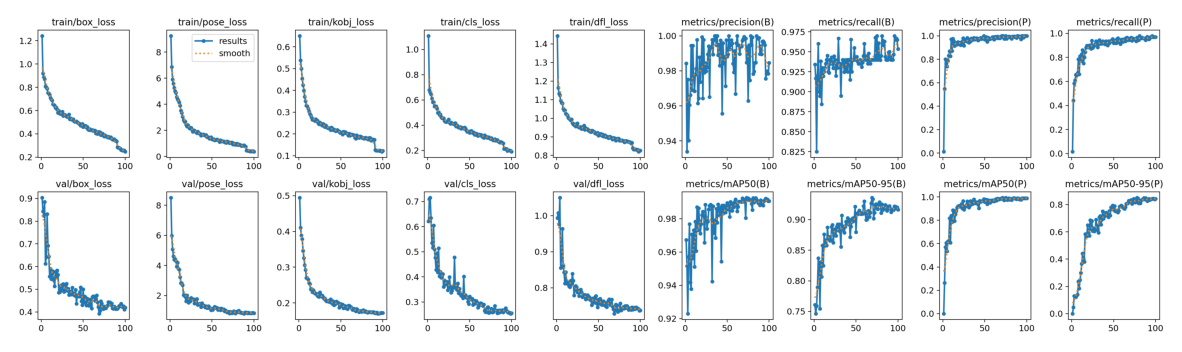

In [ ]:
results_path = "/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/results.png"
display_image(results_path)

## ☑ **Precision & Recall & F1-Score Analysis for Object Detection**

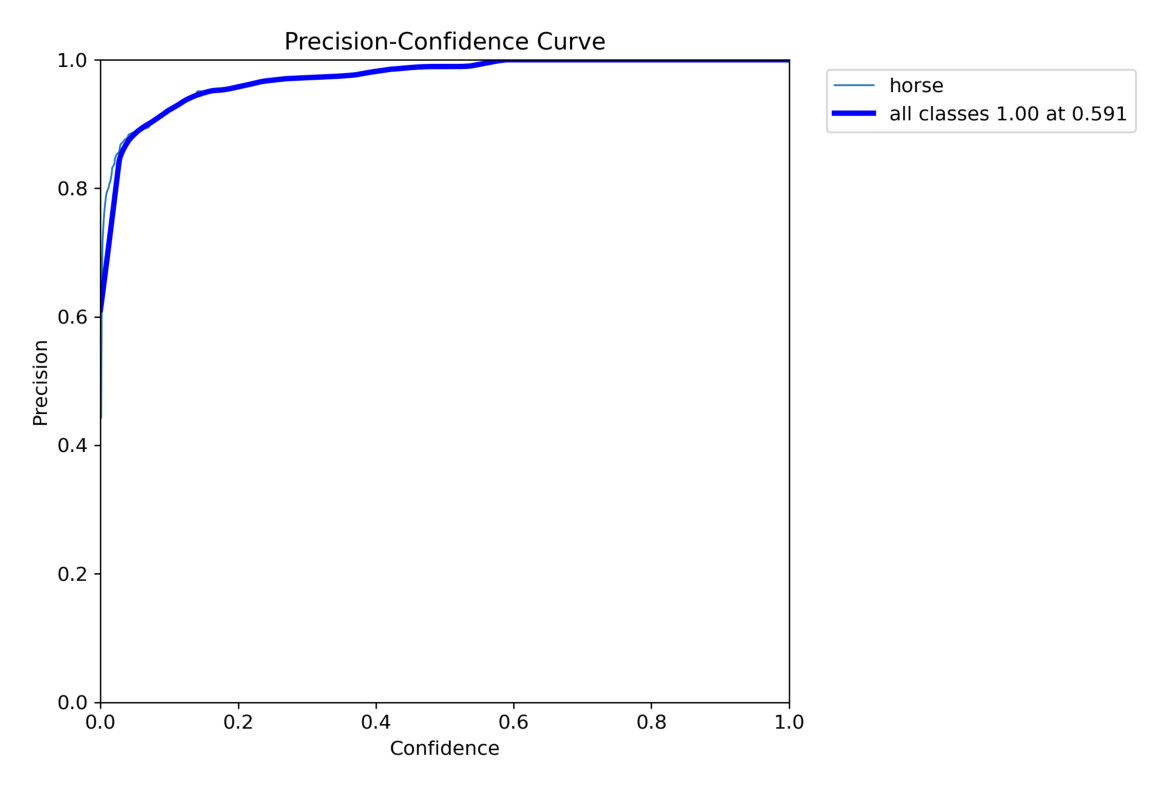

In [ ]:
p_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/BoxP_curve.png"
display_image(p_path)

###  Interpretation of the Precision-Confidence Curve :

The graph represents a Precision-Confidence Curve for a YOLOv8 model trained on the "horse10" dataset. Key observations:

- **High Precision at High Confidence:** Precision is close to 1.0 when the confidence threshold exceeds 0.6, indicating high accuracy in horse classification at high confidence levels.
- **Consistent Precision:** The model maintains high precision (above 0.8) across a wide range of confidence thresholds (0.1 to 1.0), showing robustness even at lower confidence levels.
- **Precision Drop at Low Confidence:** A sharp drop in precision occurs as confidence approaches zero, typical as lower confidence corresponds to more uncertain predictions.
- **Optimal Threshold:** The model achieves perfect precision (1.00) across all classes at a confidence threshold of approximately 0.591.

This performance suggests excellent model reliability, especially at higher confidence thresholds.


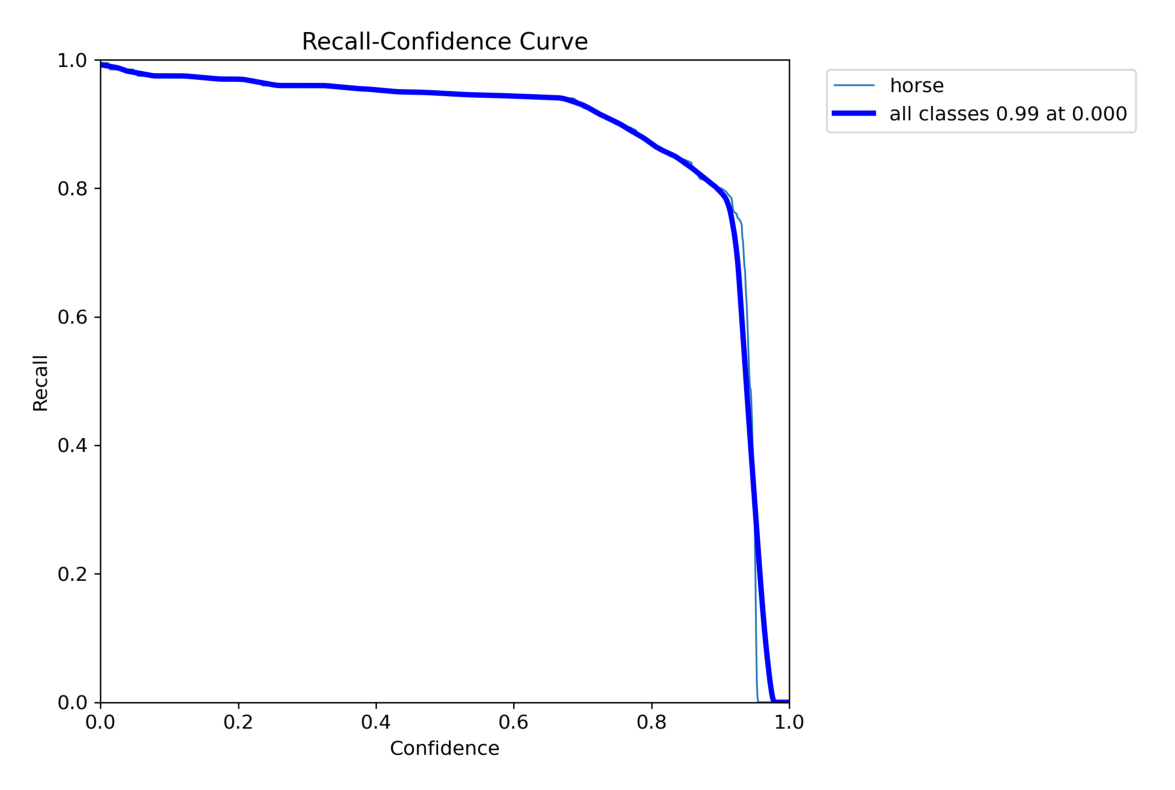

In [ ]:
r_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/BoxR_curve.png"
display_image(r_path)

### Interpretation of the Recall-Confidence Curve

The graph illustrates a Recall-Confidence Curve for a YOLOv8 model trained on the "horse10" dataset. Key observations:

- **High Recall Across Most Confidence Levels:** The recall remains very high (close to 1.0) until the confidence threshold approaches 0.8, suggesting that the model successfully identifies most of the actual 'horse' instances across a broad range of confidence levels.
- **Sharp Decline at High Confidence Thresholds:** There is a significant drop in recall as the confidence threshold increases beyond 0.8, indicating that the model starts missing actual 'horse' instances when requiring higher confidence for its predictions.
- **Optimal Performance at Low Threshold:** The label "all classes 0.99 at 0.000" indicates that the model achieves nearly perfect recall (0.99) across all classes it predicts at a confidence threshold of 0.000.

This performance indicates that the model is highly capable of detecting horses when not constrained by high confidence thresholds, making it highly effective for applications where capturing most instances is critical.


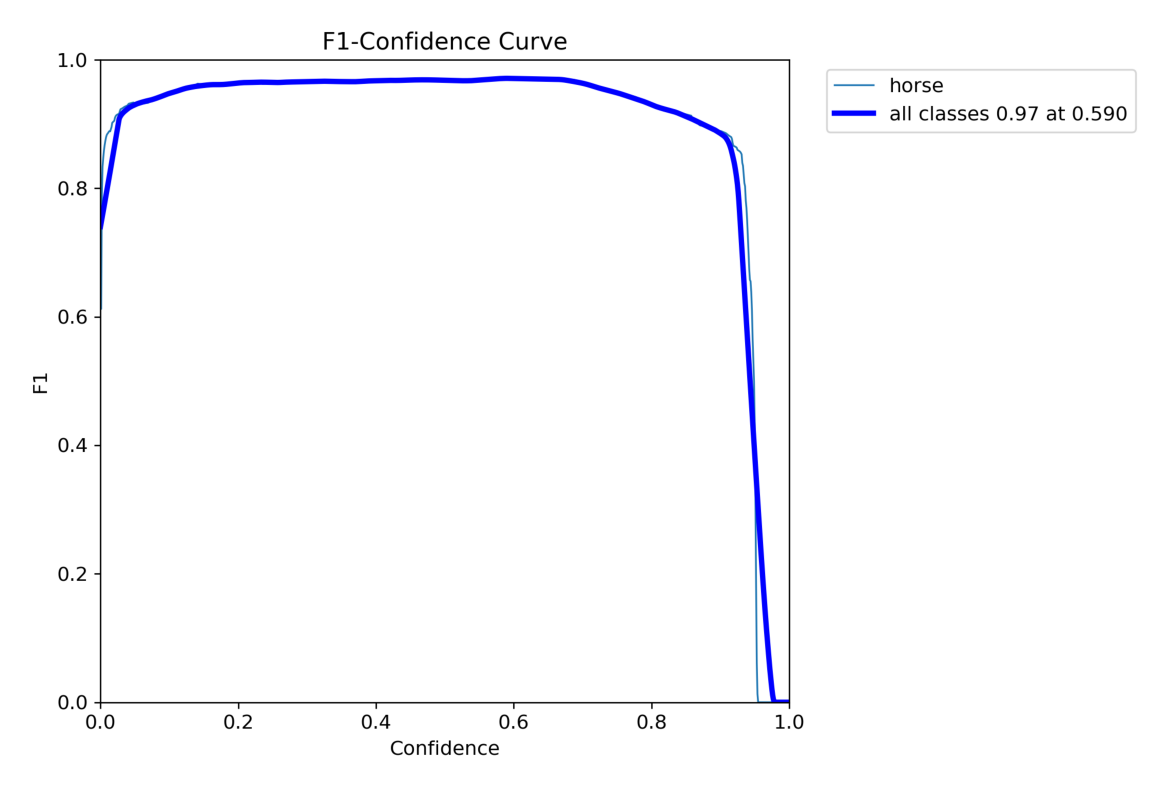

In [ ]:
f1_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/BoxF1_curve.png"
display_image(f1_path)

### Interpretation of the F1-Confidence Curve

The graph shows an F1-Confidence Curve for a YOLOv8 model trained on the "horse10" dataset. Key observations:

- **High F1 Score at Moderate to High Confidence Levels:** The F1 score remains very high (above 0.8) from confidence thresholds of 0.0 to approximately 0.8, suggesting an excellent balance between precision and recall in this range.
- **Sharp Decline at Very High Confidence Thresholds:** There is a significant drop in the F1 score as the confidence threshold increases beyond 0.8, indicating a decrease in model performance due to either missing true positives or an increase in false positives.
- **Optimal Performance at Mid-Range Confidence:** The label "all classes 0.97 at 0.5" indicates that the model achieves its optimal F1 score (0.97) across all classes at a confidence threshold of 0.5.

This curve suggests that the model achieves its best trade-off between precision and recall at a confidence threshold of 0.5, which can be considered for settings where both false positives and false negatives are equally costly.


## ☑ **Precision & Recall & F1-Score Analysis for Pose Estimation**

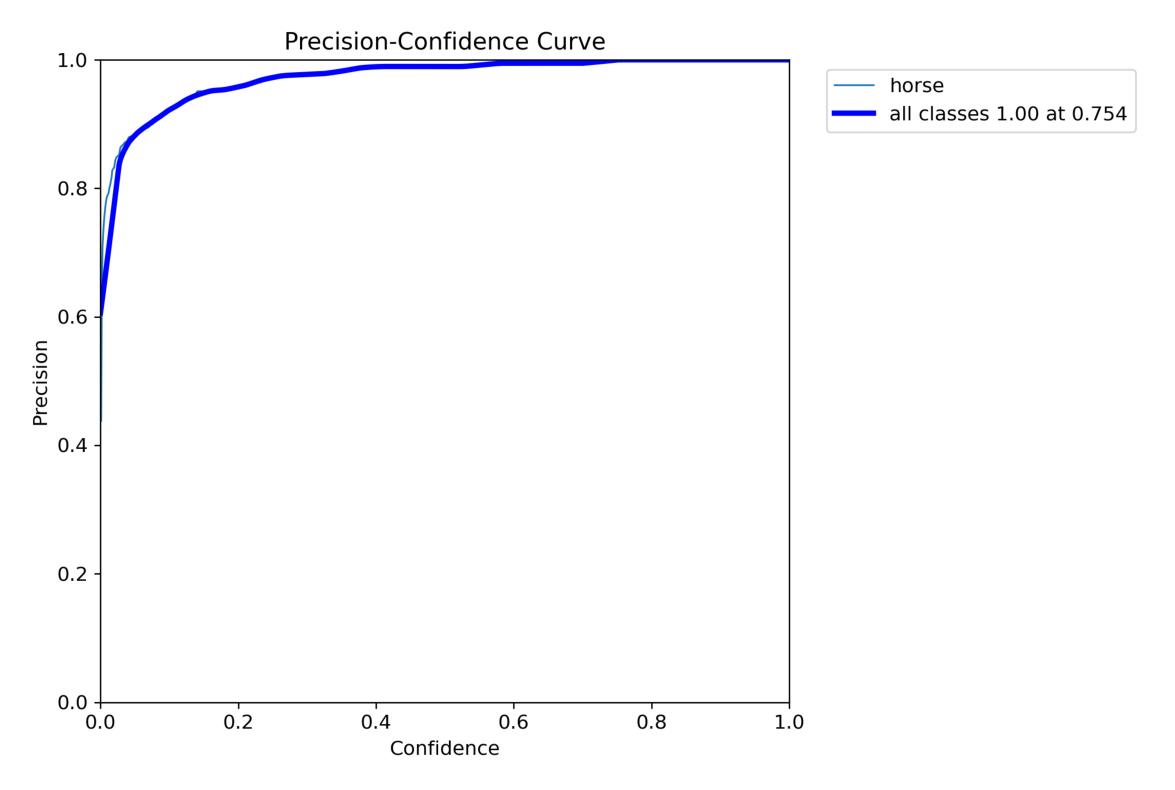

In [ ]:
posep_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/PoseP_curve.png"
display_image(posep_path)

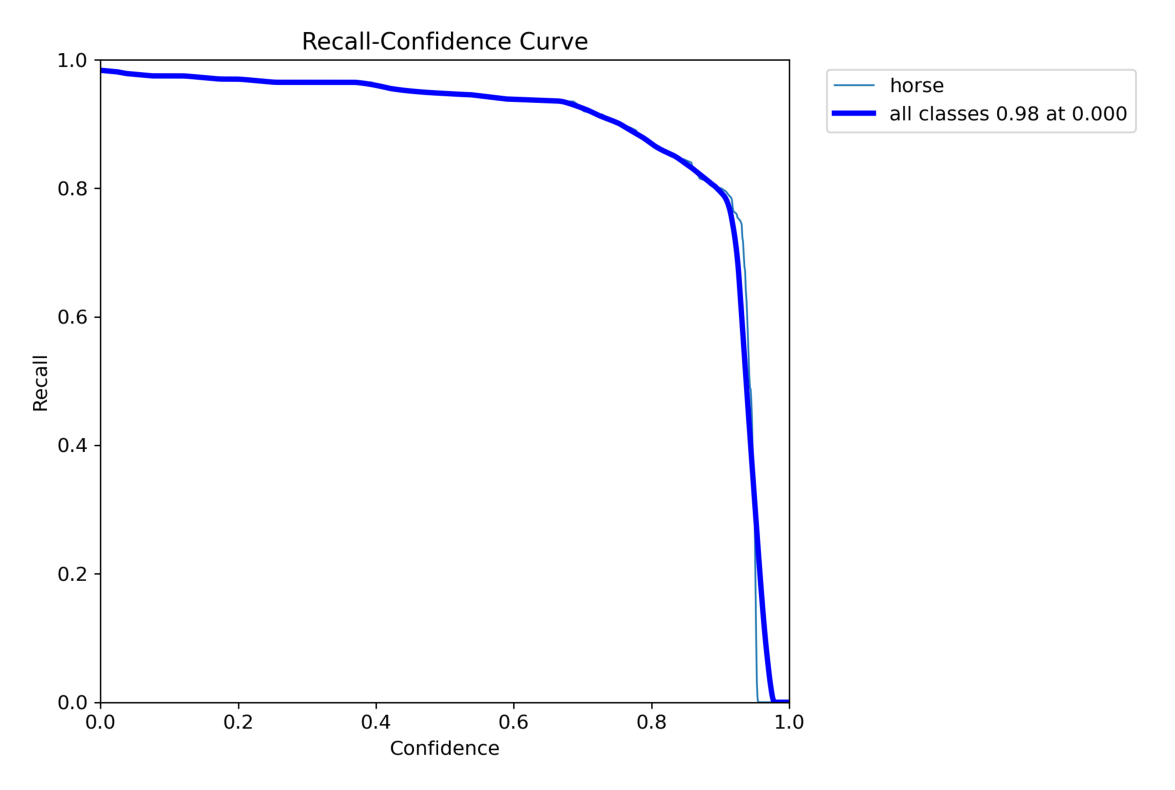

In [ ]:
poser_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/PoseR_curve.png"
display_image(poser_path)

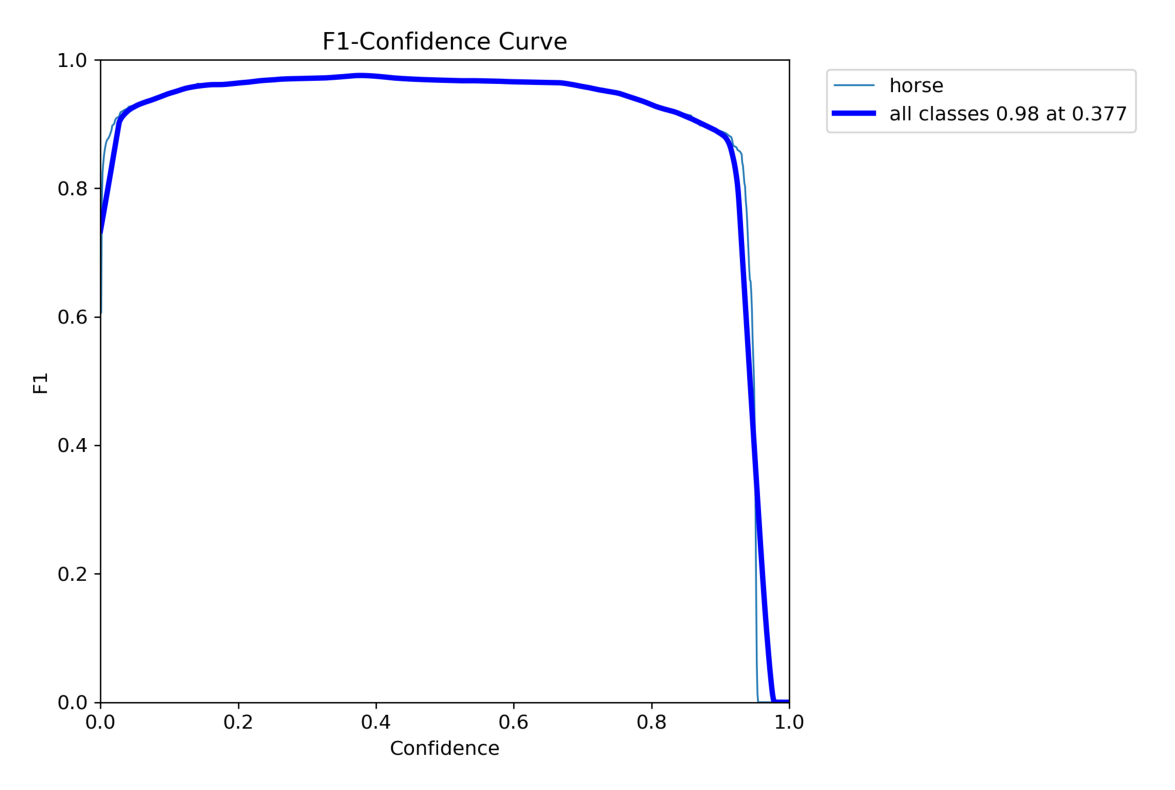

In [ ]:
posef1_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/PoseF1_curve.png"
display_image(posef1_path)

## ☑ **Confusion Matrix**

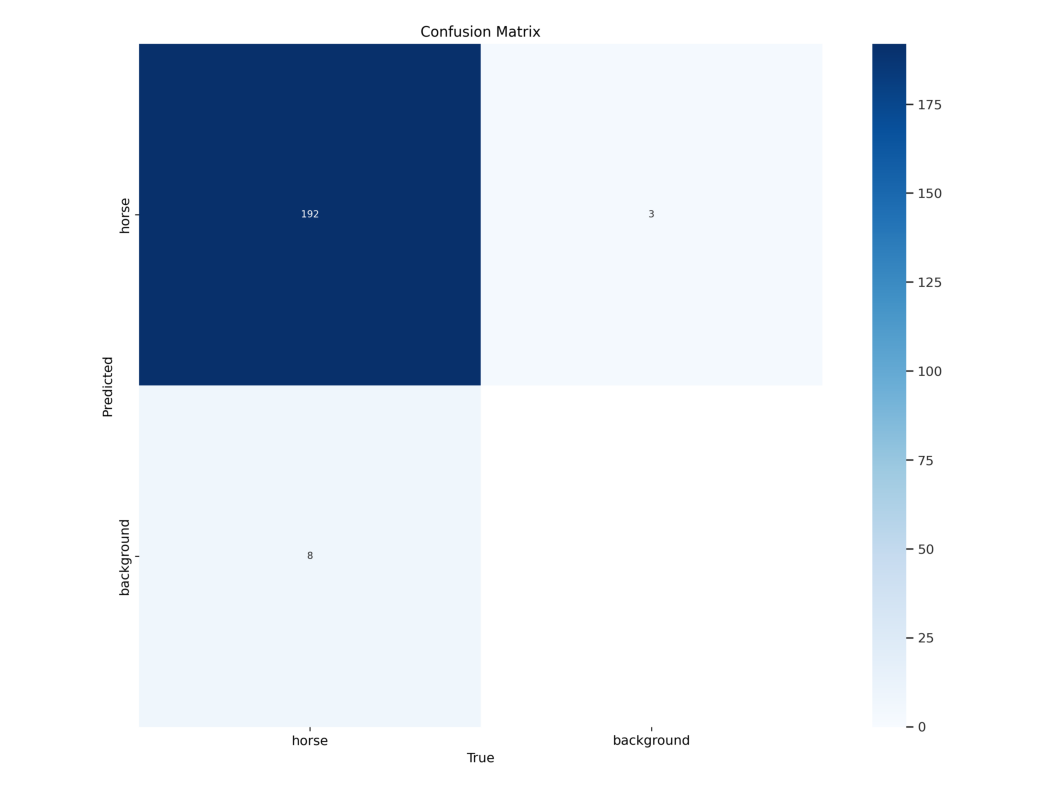

In [ ]:
confusion_matrix_path="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/confusion_matrix.png"
display_image(confusion_matrix_path)

### Interpretation of the Confusion Matrix

The confusion matrix displayed is used to evaluate the performance of your YOLOv8 model trained on the "horse10" dataset for detecting horses against the background. Here's what the matrix tells us:

- **True Positives (TP):** The model correctly predicted 'horse' 192 times. This indicates strong detection capabilities for the target class.
- **False Negatives (FN):** The model incorrectly predicted 'background' for 3 actual 'horse' instances, meaning it missed 3 horses.
- **False Positives (FP):** The model incorrectly predicted 'horse' 8 times when it was actually 'background'. This suggests some instances where the model mistakenly identified background elements as horses.
- **True Negatives (TN):** The model correctly identified the background 1 time. Since TN is very low compared to other values, this suggests that the dataset might be highly skewed towards the horse class, or the model is biased towards predicting the presence of horses.

The high number of TP and low FN suggests excellent sensitivity in detecting horses. However, the high FP indicates some precision issues, potentially due to the model's bias towards predicting horses even in some clear background cases. The overall accuracy can be considered high, but improvements could be made in distinguishing between background and horse more accurately to reduce false positives.


# ✅ **Comparative Analysis of Real and Predicted Labels**

### ☑ **Real Labels**

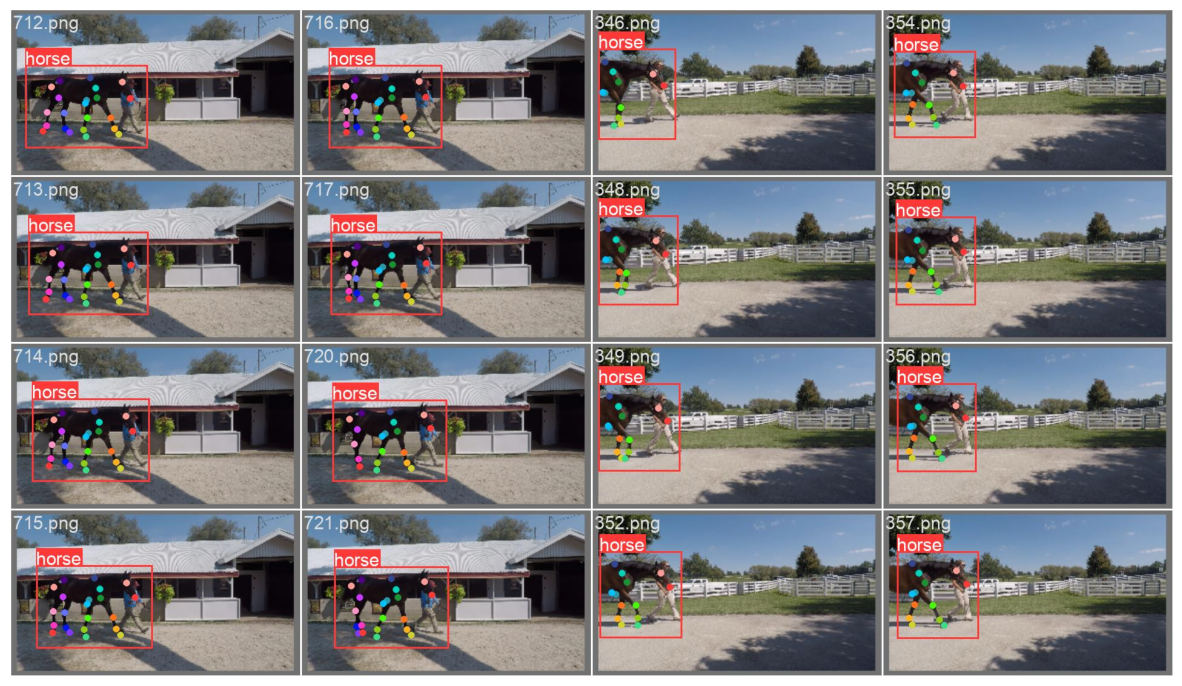

In [ ]:
val_label="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/val_batch0_labels.jpg"
display_image(val_label)

### ☑ **Predicted Labels**

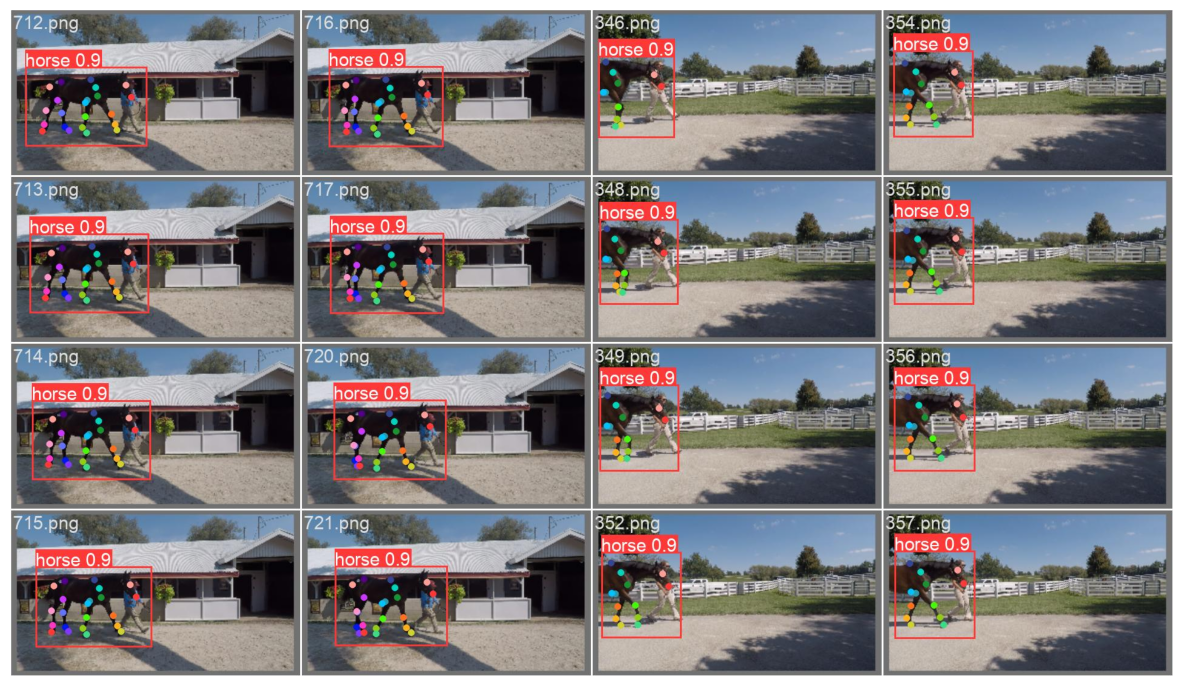

In [ ]:
val_pred="/content/drive/MyDrive/Horse-10/yolov8n-pose_100_epochs/val_batch0_pred.jpg"
display_image(val_pred)

### ☑ **Interpretation**

**The model demonstrated exceptional performance in both object detection and pose estimation tasks on the validation dataset. It accurately detected horses across various frames and accurately identified the 22 keypoints associated with the horse.**

# ✅ **Inference of Fine-Tuned Model Real Video Data**

In [ ]:
pose_model =YOLO('/content/best.pt')

In [ ]:
pose_model.predict('/content/drive/MyDrive/Beautiful Herd of Horses Running Free! (1).mp4',save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2245) /content/drive/MyDrive/Beautiful Herd of Horses Running Free! (1).mp4: 384x640 1 horse, 86.2ms
video 1/1 (frame 2/2245) /content/drive/MyDrive/Beautiful Herd of Horses Running Free! (1).mp4: 384x640 1 horse, 8.5ms
video 1/1 (frame 3/2245) /content/drive/MyDrive/Beautiful Herd of Horses Running Free! (1).mp4: 384x640 1 horse, 9.3ms
video 1/1 (frame 4/2245) /content/drive/MyDrive/Beautiful Herd of Horses Running Free! (1).mp4: 38

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'horse'}
 obb: None
 orig_img: array([[[206, 206, 218],
         [206, 206, 218],
         [206, 206, 218],
         ...,
         [229, 232, 243],
         [229, 232, 243],
         [229, 232, 243]],
 
        [[206, 206, 218],
         [206, 206, 218],
         [206, 206, 218],
         ...,
         [229, 232, 243],
         [229, 232, 243],
         [229, 232, 243]],
 
        [[206, 206, 218],
         [206, 206, 218],
         [206, 206, 218],
         ...,
         [229, 232, 243],
         [229, 232, 243],
         [229, 232, 243]],
 
        ...,
 
        [[  0,   0,   3],
         [  0,   0,   7],
         [  6,   0,  13],
         ...,
         [ 39,  41,  57],
         [ 60,  62,  78],
         [ 81,  83,  99]],
 
        [[  0,   0,   7],
         [  0,   0,   7],
         [  0,   0, 